# get context

- context is obtained from the [https://www.kaggle.com/code/mbanaei/86-2-with-only-270k-articles](https://www.kaggle.com/code/mbanaei/86-2-with-only-270k-articles) notebook

In [1]:

%%writefile get_context.py

RUN_ON_KAGGLE = False
DEBUG = True

import numpy as np
import pandas as pd 
from datasets import load_dataset, load_from_disk
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import LongformerTokenizer, LongformerForMultipleChoice
import transformers
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import unicodedata
import gc
import os

stop_words = ['each', 'you', 'the', 'use', 'used',
                  'where', 'themselves', 'nor', "it's", 'how', "don't", 'just', 'your',
                  'about', 'himself', 'with', "weren't", 'hers', "wouldn't", 'more', 'its', 'were',
                  'his', 'their', 'then', 'been', 'myself', 're', 'not',
                  'ours', 'will', 'needn', 'which', 'here', 'hadn', 'it', 'our', 'there', 'than',
                  'most', "couldn't", 'both', 'some', 'for', 'up', 'couldn', "that'll",
                  "she's", 'over', 'this', 'now', 'until', 'these', 'few', 'haven',
                  'of', 'wouldn', 'into', 'too', 'to', 'very', 'shan', 'before', 'the', 'they',
                  'between', "doesn't", 'are', 'was', 'out', 'we', 'me',
                  'after', 'has', "isn't", 'have', 'such', 'should', 'yourselves', 'or', 'during', 'herself',
                  'doing', 'in', "shouldn't", "won't", 'when', 'do', 'through', 'she',
                  'having', 'him', "haven't", 'against', 'itself', 'that',
                  'did', 'theirs', 'can', 'those',
                  'own', 'so', 'and', 'who', "you've", 'yourself', 'her', 'he', 'only',
                  'what', 'ourselves', 'again', 'had', "you'd", 'is', 'other',
                  'why', 'while', 'from', 'them', 'if', 'above', 'does', 'whom',
                  'yours', 'but', 'being', "wasn't", 'be']


from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata


def SplitList(mylist, chunk_size):
    return [mylist[offs:offs+chunk_size] for offs in range(0, len(mylist), chunk_size)]


def get_relevant_documents(df_valid):
    df_chunk_size=800
    if RUN_ON_KAGGLE:
        cohere_dataset_filtered = load_from_disk("/kaggle/working/stem-wiki-cohere-no-emb")
    else:
        cohere_dataset_filtered = load_from_disk("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wiki-stem-cohere")
    modified_texts = cohere_dataset_filtered.map(lambda example:
                                             {'temp_text':
                                              unicodedata.normalize("NFKD", f"{example['title']} {example['text']}").replace('"',"")},
                                             num_proc=2)["temp_text"]
    
    all_articles_indices = []
    all_articles_values = []
    for idx in tqdm(range(0, df_valid.shape[0], df_chunk_size)):
        df_valid_ = df_valid.iloc[idx: idx+df_chunk_size]
    
        articles_indices, merged_top_scores = retrieval(df_valid_, modified_texts)
        all_articles_indices.append(articles_indices)
        all_articles_values.append(merged_top_scores)
        
    article_indices_array =  np.concatenate(all_articles_indices, axis=0)
    articles_values_array = np.concatenate(all_articles_values, axis=0).reshape(-1)
    
    top_per_query = article_indices_array.shape[1]
    articles_flatten = [(
                         articles_values_array[index],
                         cohere_dataset_filtered[idx.item()]["title"],
                         unicodedata.normalize("NFKD", cohere_dataset_filtered[idx.item()]["text"]),
                        )
                        for index,idx in enumerate(article_indices_array.reshape(-1))]
    retrieved_articles = SplitList(articles_flatten, top_per_query)
    return retrieved_articles



def retrieval(df_valid, modified_texts):
    
    corpus_df_valid = df_valid.apply(lambda row:
                                     f'{row["prompt"]}\n{row["prompt"]}\n{row["prompt"]}\n{row["A"]}\n{row["B"]}\n{row["C"]}\n{row["D"]}\n{row["E"]}',
                                     axis=1).values
    vectorizer1 = TfidfVectorizer(ngram_range=(1,2),
                                 token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                                 stop_words=stop_words)
    vectorizer1.fit(corpus_df_valid)
    vocab_df_valid = vectorizer1.get_feature_names_out()
    vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                 token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                                 stop_words=stop_words,
                                 vocabulary=vocab_df_valid)
    vectorizer.fit(modified_texts[:500000])
    corpus_tf_idf = vectorizer.transform(corpus_df_valid)
    
    print(f"length of vectorizer vocab is {len(vectorizer.get_feature_names_out())}")

    chunk_size = 100000
    top_per_chunk = 30
    top_per_query = 30

    all_chunk_top_indices = []
    all_chunk_top_values = []

    for idx in tqdm(range(0, len(modified_texts), chunk_size)):
        wiki_vectors = vectorizer.transform(modified_texts[idx: idx+chunk_size])
        temp_scores = (corpus_tf_idf * wiki_vectors.T).toarray()
        chunk_top_indices = temp_scores.argpartition(-top_per_chunk, axis=1)[:, -top_per_chunk:]
        chunk_top_values = temp_scores[np.arange(temp_scores.shape[0])[:, np.newaxis], chunk_top_indices]

        all_chunk_top_indices.append(chunk_top_indices + idx)
        all_chunk_top_values.append(chunk_top_values)

    top_indices_array = np.concatenate(all_chunk_top_indices, axis=1)
    top_values_array = np.concatenate(all_chunk_top_values, axis=1)
    
    merged_top_scores = np.sort(top_values_array, axis=1)[:,-top_per_query:]
    merged_top_indices = top_values_array.argsort(axis=1)[:,-top_per_query:]
    articles_indices = top_indices_array[np.arange(top_indices_array.shape[0])[:, np.newaxis], merged_top_indices]
    
    return articles_indices, merged_top_scores

if RUN_ON_KAGGLE:
    if DEBUG:
        df = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/train.csv", index_col="id")
    else:
        df = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/test.csv", index_col="id")
else:
    
    df_1 = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-llm-science-exam/train.csv", index_col="id")
    df = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/dataset_wiki_new_1/dataset_wiki_new_1_balanced.csv")
    df['id'] = np.arange(0, len(df))
    df = pd.concat([df, df_1], axis=0)
    df['id'] = np.arange(0, len(df))
    # df = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/data_dumps/more_questions/more_questions_raw_questions_wiki_sci_3.csv", index_col="id").sample(n=2048).reset_index(drop=True)


retrieved_articles = get_relevant_documents(df)
gc.collect()


contexts = []

for index in tqdm(range(df.shape[0])):
    row = df.iloc[index]
    # question is 'prompt'
    question = row['prompt']
    options = [row['A'], row['B'], row['C'], row['D'], row['E']]
    context = f"{retrieved_articles[index][-4][2]}\n{retrieved_articles[index][-3][2]}\n{retrieved_articles[index][-2][2]}\n{retrieved_articles[index][-1][2]}"
    contexts.append(context)
    
df['context'] = contexts
df.to_parquet("test_with_context.parquet")

Overwriting get_context.py


In [2]:
import pandas as pd

df = pd.read_parquet("test_with_context.parquet")

# save as csv
df.to_csv("test_with_context.csv")

In [2]:
!python get_context.py

Loading cached processed dataset at /home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wiki-stem-cohere/cache-e94d488c6798573e_*_of_00002.arrow
  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'd', 'doesn', 'don', 'isn', 'll', 's', 'shouldn', 't', 've', 'wasn', 'weren', 'won'] not in stop_words.
  warnings.warn(
length of vectorizer vocab is 28413

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 29622.88it/s]


answer
A    109
B    108
D    103
C    100
E     80
Name: count, dtype: int64


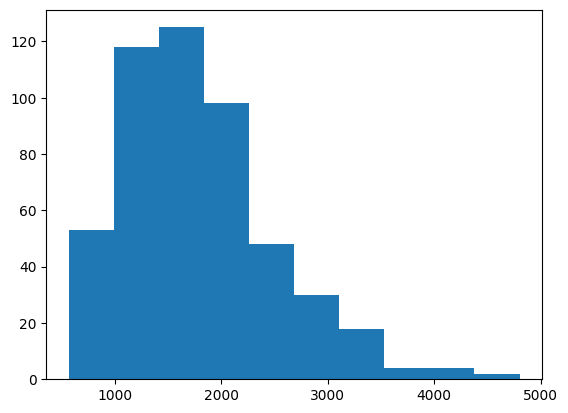

In [3]:
import pandas as pd
df = pd.read_parquet("test_with_context.parquet")
# remove rows for which answer is not either A, B, C, D or E. Make direct comparison
df = df[df['answer'].isin(['A', 'B', 'C', 'D', 'E'])]
print(df['answer'].value_counts())

df['context_len'] = df['context'].apply(lambda x: len(x))
import matplotlib.pyplot as plt

plt.hist(df['context_len'], bins=10);

# llm-science-run-context-2

In [4]:
import os, time
import gc
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import blingfire as bf
from __future__ import annotations

from collections.abc import Iterable

import faiss
from faiss import write_index, read_index

from sentence_transformers import SentenceTransformer

import torch
import ctypes
libc = ctypes.CDLL("libc.so.6")

from dataclasses import dataclass
from typing import Optional, Union

import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from torch.utils.data import DataLoader

from scipy.special import softmax


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.9
CUDA SETUP: Detected CUDA version 121
CUDA SETUP: Loading binary /home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda121.so...


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /home/viktor/miniconda3/envs/torch-env did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('vs/workbench/api/node/extensionHostProcess')}
  warn(msg)
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//matplotlib_inline.backend_inline'), PosixPath('module')}
  warn(msg)


In [5]:
DEVICE = 0
MAX_LENGTH = 384
BATCH_SIZE = 32

DEBUG = True
# DEBUG = False if len(trn)!=200 else True # If you want to save GPU Quota, check off this comment-out. But cannot get accurate weight on saving notebook
FILTER_LEN = 1 if DEBUG else 9
IND_SEARCH = 1 if DEBUG else 7
NUM_SENTENCES_INCLUDE = 1 if DEBUG else 25
CONTEXT_LEN = 1000 if DEBUG else 2305
VAL_SIZE = 200 if DEBUG else 1500

In [6]:

test_df = pd.read_parquet("test_with_context.parquet")
if 'answer' in test_df.columns:
    test_df = test_df[test_df['answer'].isin(['A', 'B', 'C', 'D', 'E'])]
    print(test_df['answer'].value_counts())

test_df.index = list(range(len(test_df)))
test_df['id'] = list(range(len(test_df)))
if DEBUG:
    
    def split_prompt(prompt, max_size=400, stride=200): 
        """
        Splits a given prompt into chunks of size max_size with a given stride.
        """
        chunks = []
        for i in range(0, len(prompt) - max_size + 1, stride):
            chunks.append(prompt[i:i+max_size])
        if len(prompt) % max_size != 0:
            chunks.append(prompt[-max_size:])
        return chunks

    # Apply the split_prompt function to each row in the "prompt" column
    test_df["context"] = test_df["context"].apply(lambda x: split_prompt(x))

    # Explode the "prompt" column
    test_df = test_df.explode("context", ignore_index=True)
    
    
    test_df['answer_all'] = test_df.apply(lambda x: " ".join([
        f"a) {x['A']}",
        f"b) {x['B']}",
        f"c) {x['C']}",
        f"d) {x['D']}",
        f"e) {x['E']}"
    ]), axis=1)
    test_df["prompt_and_context"] = test_df["context"].apply(lambda x: x[:CONTEXT_LEN]) + " #### " +  test_df["prompt"] # + " Possible answers: " +  test_df["answer_all"]
    
else:
    test_df['answer_all'] = test_df.apply(lambda x: " ".join([
        f"a) {x['A']}",
        f"b) {x['B']}",
        f"c) {x['C']}",
        f"d) {x['D']}",
        f"e) {x['E']}"
    ]), axis=1)
    test_df["prompt_and_context"] = test_df["context"].apply(lambda x: x[:CONTEXT_LEN]) + " #### " +  test_df["prompt"] # + " Possible answers: " # +  test_df["answer_all"]
    
    
if "answer" not in test_df.columns:
    test_df['answer'] = 'A'

answer
A    109
B    108
D    103
C    100
E     80
Name: count, dtype: int64


In [7]:

options = 'ABCDE'
indices = list(range(5))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}

def preprocess(example):
  
    first_sentence = [example['prompt_and_context']] * 5
    second_sentence = []
    for option in options:
        second_sentence.append(example[option])
    
    tokenized_example = tokenizer(first_sentence, second_sentence, truncation='only_first')
    tokenized_example['label'] = option_to_index[example['answer']]
    return tokenized_example

In [8]:
test_df

,prompt,A,B,C,D,E,answer,id,context,answer_all,prompt_and_context
0,What is the method of transcription in the lif...,RNA-templated transcription is the method of t...,Transcription occurs through a unique mechanis...,Reverse transcription is the method of transcr...,DNA-templated transcription is the method of t...,Transcription does not occur in the life cycle...,D,0,The given phonetic transcription is how the pr...,a) RNA-templated transcription is the method o...,The given phonetic transcription is how the pr...
1,What is the method of transcription in the lif...,RNA-templated transcription is the method of t...,Transcription occurs through a unique mechanis...,Reverse transcription is the method of transcr...,DNA-templated transcription is the method of t...,Transcription does not occur in the life cycle...,D,0,rd because it does not have a one-to-one corre...,a) RNA-templated transcription is the method o...,rd because it does not have a one-to-one corre...
2,What is the method of transcription in the lif...,RNA-templated transcription is the method of t...,Transcription occurs through a unique mechanis...,Reverse transcription is the method of transcr...,DNA-templated transcription is the method of t...,Transcription does not occur in the life cycle...,D,0,"here it is more commonly termed ""captioning.""\...",a) RNA-templated transcription is the method o...,"here it is more commonly termed ""captioning.""\..."
3,What is the role of the viral fiber glycoprote...,The viral fiber glycoproteins are involved in ...,The viral fiber glycoproteins code for 40 prot...,The viral fiber glycoproteins are responsible ...,The viral fiber glycoproteins mediate endocyto...,The viral fiber glycoproteins are responsible ...,D,1,Viral glycoprotein-receptor interactions are r...,a) The viral fiber glycoproteins are involved ...,Viral glycoprotein-receptor interactions are r...
4,What is the role of the viral fiber glycoprote...,The viral fiber glycoproteins are involved in ...,The viral fiber glycoproteins code for 40 prot...,The viral fiber glycoproteins are responsible ...,The viral fiber glycoproteins mediate endocyto...,The viral fiber glycoproteins are responsible ...,D,1,hile the transmembrane (TM) glycoproteins anch...,a) The viral fiber glycoproteins are involved ...,hile the transmembrane (TM) glycoproteins anch...
...,...,...,...,...,...,...,...,...,...,...,...
4205,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,C,499,ropagate at the speed of light regardless of c...,a) Arthur Eddington showed that two of Einstei...,ropagate at the speed of light regardless of c...
4206,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,C,499,he full general theory of relativity because a...,a) Arthur Eddington showed that two of Einstei...,he full general theory of relativity because a...
4207,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,C,499,reported that the singularities in question w...,a) Arthur Eddington showed that two of Einstei...,reported that the singularities in question w...
4208,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddin

In [9]:
@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = "label" if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [10]:
# model_dir = "/kaggle/input/how-to-train-open-book-model-part-1/model_v2"
# model_dir = "/kaggle/input/llm-submissions-viktor/work_dirs/deberta-v3-data-wiki_sci-with-wiki-sentence-context-eval-kaggle-all-folds-grad-accum-128-60k/deberta-v3-large-2023-09-05-07-35-55/checkpoint-3281"
model_dir ="/home/viktor/Documents/kaggle/kaggle_llm/work_dirs/160k-viktor-and-deotte-dataset-deotte-preproc-deberta/deberta-v3-large-2023-09-17-10-00-20/checkpoint-14400"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


DebertaV2ForMultipleChoice(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_aff

In [11]:
tokenized_test_dataset = Dataset.from_pandas(test_df[['id', 'prompt_and_context', 'A', 'B', 'C', 'D', 'E', 'answer']].drop(columns=['id'])).map(preprocess, remove_columns=['prompt_and_context', 'A', 'B', 'C', 'D', 'E', 'answer'])
# tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)

Map:   0%|          | 0/4210 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# viktor

In [12]:
test_predictions_viktor = []


for batch in tqdm(test_dataloader):
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictions_viktor.append(outputs.logits.cpu().detach())
    
test_predictions_viktor = torch.cat(test_predictions_viktor)

  0%|          | 0/4210 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
test_predictions_viktor = sigmoid(test_predictions_viktor).numpy()


In [14]:
test_predictions_viktor.shape

(4210, 5)

In [15]:
test_df['predictions'] = test_predictions_viktor.tolist()
test_df

,prompt,A,B,C,D,E,answer,id,context,answer_all,prompt_and_context,predictions
0,What is the method of transcription in the lif...,RNA-templated transcription is the method of t...,Transcription occurs through a unique mechanis...,Reverse transcription is the method of transcr...,DNA-templated transcription is the method of t...,Transcription does not occur in the life cycle...,D,0,The given phonetic transcription is how the pr...,a) RNA-templated transcription is the method o...,The given phonetic transcription is how the pr...,"[0.8101109862327576, 0.3025016486644745, 0.202..."
1,What is the method of transcription in the lif...,RNA-templated transcription is the method of t...,Transcription occurs through a unique mechanis...,Reverse transcription is the method of transcr...,DNA-templated transcription is the method of t...,Transcription does not occur in the life cycle...,D,0,rd because it does not have a one-to-one corre...,a) RNA-templated transcription is the method o...,rd because it does not have a one-to-one corre...,"[0.7801524996757507, 0.4729377329349518, 0.436..."
2,What is the method of transcription in the lif...,RNA-templated transcription is the method of t...,Transcription occurs through a unique mechanis...,Reverse transcription is the method of transcr...,DNA-templated transcription is the method of t...,Transcription does not occur in the life cycle...,D,0,"here it is more commonly termed ""captioning.""\...",a) RNA-templated transcription is the method o...,"here it is more commonly termed ""captioning.""\...","[0.7622959613800049, 0.3203194737434387, 0.383..."
3,What is the role of the viral fiber glycoprote...,The viral fiber glycoproteins are involved in ...,The viral fiber glycoproteins code for 40 prot...,The viral fiber glycoproteins are responsible ...,The viral fiber glycoproteins mediate endocyto...,The viral fiber glycoproteins are responsible ...,D,1,Viral glycoprotein-receptor interactions are r...,a) The viral fiber glycoproteins are involved ...,Viral glycoprotein-receptor interactions are r...,"[0.010664276778697968, 0.06569230556488037, 0...."
4,What is the role of the viral fiber glycoprote...,The viral fiber glycoproteins are involved in ...,The viral fiber glycoproteins code for 40 prot...,The viral fiber glycoproteins are responsible ...,The viral fiber glycoproteins mediate endocyto...,The viral fiber glycoproteins are responsible ...,D,1,hile the transmembrane (TM) glycoproteins anch...,a) The viral fiber glycoproteins are involved ...,hile the transmembrane (TM) glycoproteins anch...,"[0.015026367269456387, 0.05148383602499962, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
4205,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,C,499,ropagate at the speed of light regardless of c...,a) Arthur Eddington showed that two of Einstei...,ropagate at the speed of light regardless of c...,"[0.9864804148674011, 0.9629263281822205, 0.989..."
4206,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,C,499,he full general theory of relativity because a...,a) Arthur Eddington showed that two of Einstei...,he full general theory of relativity because a...,"[0.9874871969223022, 0.977417528629303, 0.9906..."
4207,What did Arthur Eddington discover about two o...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einstein's...,Arthur Eddington showed that two of Einst

In [16]:


# save test_df as rag_2.parquet
test_df.to_parquet("wiki_sci_3_rag_2.parquet")

In [17]:
import pandas as pd
test_df = pd.read_parquet("wiki_sci_3_rag_2.parquet")

In [18]:
import numpy as np

ids = sorted(list(set(test_df['id'].values)))

avgs = []
maxes  = []
answers = []
diffs_maxes = []

for id in ids:
    df_id = test_df[test_df['id']==id].reset_index(drop=True)
    answer = df_id['answer'].values[0]
    answers.append(answer)
    
    predictions = np.vstack(df_id['predictions'].values)
    
    predictions_avg = np.mean(predictions, axis=0)
    predictions_max = np.max(predictions, axis=0)
    
    predictions_diff = predictions - predictions_avg
    predictions_diff_max = np.max(predictions_diff, axis=0)
    
    
    avgs.append(predictions_avg)
    maxes.append(predictions_max)
    diffs_maxes.append(predictions_diff_max)
    
    diffs_maxes_argmax = np.argmax(diffs_maxes, axis=1)
    
    

In [19]:
df_agg = pd.DataFrame({'id': ids, 'answer': answers, 'avg': avgs, 'max': maxes, 'diff_max': diffs_maxes, 'answers': answers})
df_agg

,id,answer,avg,max,diff_max,answers
0,0,D,"[0.7841864824295044, 0.365252951780955, 0.3408...","[0.8101109862327576, 0.4729377329349518, 0.436...","[0.025924503803253174, 0.10768478115399677, 0....",D
1,1,D,"[0.01348709903488105, 0.04889114268801429, 0.0...","[0.023958779871463776, 0.07085713744163513, 0....","[0.010471680836582726, 0.021965994753620842, 0...",D
2,2,A,"[0.022143802295128506, 0.06562760596474011, 0....","[0.03270862624049187, 0.10062923282384872, 0.2...","[0.010564823945363361, 0.03500162685910861, 0....",A
3,3,B,"[0.2759467549622059, 0.4401126056909561, 0.338...","[0.5398164391517639, 0.48443925380706787, 0.42...","[0.26386968418955803, 0.044326648116111755, 0....",B
4,4,A,"[0.7641253603829278, 0.2921374539534251, 0.241...","[0.9774370193481445, 0.4866539537906647, 0.497...","[0.21331165896521675, 0.19451649983723956, 0.2...",A
...,...,...,...,...,...,...
495,495,C,"[0.534287840127945, 0.14227384328842163, 0.988...","[0.7420330047607422, 0.24698862433433533, 0.99...","[0.20774516463279724, 0.1047147810459137, 0.00...",C
496,496,B,"[0.9662010073661804, 0.9888747096061706, 0.986...","[0.9885849356651306, 0.9983788728713989, 0.996...","[0.022383928298950195, 0.009504163265228294, 0...",B
497,497,B,"[0.9921214481194814, 0.9936448832352957, 0.973...","[0.9992356300354004, 0.9994922876358032, 0.979...","[0.007114181915918949, 0.005847404400507572, 0...",B
498,498,D,"[0.7139628529548645, 0.8319788106850216, 0.853...","[0.8354699015617371, 0.9652966260910034, 0.965...","[0.12150704860687256, 0.13331781540598187, 0.1...",D


In [20]:

options = 'ABCDE'
indices = list(range(5))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}


df_agg['pred_avg'] = df_agg['avg'].apply(lambda x: index_to_option[np.argmax(x)])
df_agg['pred_max'] = df_agg['max'].apply(lambda x: index_to_option[np.argmax(x)])
df_agg['pred_diff_max'] = df_agg['diff_max'].apply(lambda x: index_to_option[np.argmax(x)])

# 2nd to argmax
df_agg['pred_avg_2'] = df_agg['avg'].apply(lambda x: index_to_option[np.argsort(x)[-2]])
df_agg['pred_max_2'] = df_agg['max'].apply(lambda x: index_to_option[np.argsort(x)[-2]])
df_agg['pred_diff_max_2'] = df_agg['diff_max'].apply(lambda x: index_to_option[np.argsort(x)[-2]])

# 3nd to argmax
df_agg['pred_avg_3'] = df_agg['avg'].apply(lambda x: index_to_option[np.argsort(x)[-3]])
df_agg['pred_max_3'] = df_agg['max'].apply(lambda x: index_to_option[np.argsort(x)[-3]])
df_agg['pred_diff_max_3'] = df_agg['diff_max'].apply(lambda x: index_to_option[np.argsort(x)[-3]])

df_agg  

,id,answer,avg,max,diff_max,answers,pred_avg,pred_max,pred_diff_max,pred_avg_2,pred_max_2,pred_diff_max_2,pred_avg_3,pred_max_3,pred_diff_max_3
0,0,D,"[0.7841864824295044, 0.365252951780955, 0.3408...","[0.8101109862327576, 0.4729377329349518, 0.436...","[0.025924503803253174, 0.10768478115399677, 0....",D,A,A,B,D,D,C,B,B,D
1,1,D,"[0.01348709903488105, 0.04889114268801429, 0.0...","[0.023958779871463776, 0.07085713744163513, 0....","[0.010471680836582726, 0.021965994753620842, 0...",D,D,D,D,E,E,E,C,C,C
2,2,A,"[0.022143802295128506, 0.06562760596474011, 0....","[0.03270862624049187, 0.10062923282384872, 0.2...","[0.010564823945363361, 0.03500162685910861, 0....",A,C,C,C,E,E,E,B,B,D
3,3,B,"[0.2759467549622059, 0.4401126056909561, 0.338...","[0.5398164391517639, 0.48443925380706787, 0.42...","[0.26386968418955803, 0.044326648116111755, 0....",B,B,A,A,C,B,E,E,C,C
4,4,A,"[0.7641253603829278, 0.2921374539534251, 0.241...","[0.9774370193481445, 0.4866539537906647, 0.497...","[0.21331165896521675, 0.19451649983723956, 0.2...",A,A,A,D,B,D,E,D,E,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,C,"[0.534287840127945, 0.14227384328842163, 0.988...","[0.7420330047607422, 0.24698862433433533, 0.99...","[0.20774516463279724, 0.1047147810459137, 0.00...",C,C,C,A,A,A,D,E,E,E
496,496,B,"[0.9662010073661804, 0.9888747096061706, 0.986...","[0.9885849356651306, 0.9983788728713989, 0.996...","[0.022383928298950195, 0.009504163265228294, 0...",B,B,B,E,C,C,D,A,A,A
497,497,B,"[0.9921214481194814, 0.9936448832352957, 0.973...","[0.9992356300354004, 0.9994922876358032, 0.979...","[0.007114181915918949, 0.005847404400507572, 0...",B,B,B,D,A,A,A,D,D,E
498,498,D,"[0.7139628529548645, 0.8319788106850216, 0.853...","[0.8354699015617371, 0.9652966260910034, 0.965...","[0.12150704860687256, 0.13331781540598187, 0.1...",D,D,D,E,C,C,B,B,B,A


In [21]:
avg_values = np.vstack(df_agg['avg'].values)
predictions_overall = np.argsort(-avg_values)[:,:3]
predictions_as_answer_letters = np.array(list('ABCDE'))[predictions_overall]
df_agg['avg_prediction'] = [
    ' '.join(row) for row in predictions_as_answer_letters[:, :3]
]
df_agg

,id,answer,avg,max,diff_max,answers,pred_avg,pred_max,pred_diff_max,pred_avg_2,pred_max_2,pred_diff_max_2,pred_avg_3,pred_max_3,pred_diff_max_3,avg_prediction
0,0,D,"[0.7841864824295044, 0.365252951780955, 0.3408...","[0.8101109862327576, 0.4729377329349518, 0.436...","[0.025924503803253174, 0.10768478115399677, 0....",D,A,A,B,D,D,C,B,B,D,A D B
1,1,D,"[0.01348709903488105, 0.04889114268801429, 0.0...","[0.023958779871463776, 0.07085713744163513, 0....","[0.010471680836582726, 0.021965994753620842, 0...",D,D,D,D,E,E,E,C,C,C,D E C
2,2,A,"[0.022143802295128506, 0.06562760596474011, 0....","[0.03270862624049187, 0.10062923282384872, 0.2...","[0.010564823945363361, 0.03500162685910861, 0....",A,C,C,C,E,E,E,B,B,D,C E B
3,3,B,"[0.2759467549622059, 0.4401126056909561, 0.338...","[0.5398164391517639, 0.48443925380706787, 0.42...","[0.26386968418955803, 0.044326648116111755, 0....",B,B,A,A,C,B,E,E,C,C,B C E
4,4,A,"[0.7641253603829278, 0.2921374539534251, 0.241...","[0.9774370193481445, 0.4866539537906647, 0.497...","[0.21331165896521675, 0.19451649983723956, 0.2...",A,A,A,D,B,D,E,D,E,C,A B D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,C,"[0.534287840127945, 0.14227384328842163, 0.988...","[0.7420330047607422, 0.24698862433433533, 0.99...","[0.20774516463279724, 0.1047147810459137, 0.00...",C,C,C,A,A,A,D,E,E,E,C A E
496,496,B,"[0.9662010073661804, 0.9888747096061706, 0.986...","[0.9885849356651306, 0.9983788728713989, 0.996...","[0.022383928298950195, 0.009504163265228294, 0...",B,B,B,E,C,C,D,A,A,A,B C A
497,497,B,"[0.9921214481194814, 0.9936448832352957, 0.973...","[0.9992356300354004, 0.9994922876358032, 0.979...","[0.007114181915918949, 0.005847404400507572, 0...",B,B,B,D,A,A,A,D,D,E,B A D
498,498,D,"[0.7139628529548645, 0.8319788106850216, 0.853...","[0.8354699015617371, 0.9652966260910034, 0.965...","[0.12150704860687256, 0.13331781540598187, 0.1...",D,D,D,E,C,C,B,B,B,A,D C B


In [22]:
avg_values = np.vstack(df_agg['max'].values)
predictions_overall = np.argsort(-avg_values)[:,:3]
predictions_as_answer_letters = np.array(list('ABCDE'))[predictions_overall]
df_agg['max_prediction'] = [
    ' '.join(row) for row in predictions_as_answer_letters[:, :3]
]
df_agg

,id,answer,avg,max,diff_max,answers,pred_avg,pred_max,pred_diff_max,pred_avg_2,pred_max_2,pred_diff_max_2,pred_avg_3,pred_max_3,pred_diff_max_3,avg_prediction,max_prediction
0,0,D,"[0.7841864824295044, 0.365252951780955, 0.3408...","[0.8101109862327576, 0.4729377329349518, 0.436...","[0.025924503803253174, 0.10768478115399677, 0....",D,A,A,B,D,D,C,B,B,D,A D B,A D B
1,1,D,"[0.01348709903488105, 0.04889114268801429, 0.0...","[0.023958779871463776, 0.07085713744163513, 0....","[0.010471680836582726, 0.021965994753620842, 0...",D,D,D,D,E,E,E,C,C,C,D E C,D E C
2,2,A,"[0.022143802295128506, 0.06562760596474011, 0....","[0.03270862624049187, 0.10062923282384872, 0.2...","[0.010564823945363361, 0.03500162685910861, 0....",A,C,C,C,E,E,E,B,B,D,C E B,C E B
3,3,B,"[0.2759467549622059, 0.4401126056909561, 0.338...","[0.5398164391517639, 0.48443925380706787, 0.42...","[0.26386968418955803, 0.044326648116111755, 0....",B,B,A,A,C,B,E,E,C,C,B C E,A B C
4,4,A,"[0.7641253603829278, 0.2921374539534251, 0.241...","[0.9774370193481445, 0.4866539537906647, 0.497...","[0.21331165896521675, 0.19451649983723956, 0.2...",A,A,A,D,B,D,E,D,E,C,A B D,A D E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,C,"[0.534287840127945, 0.14227384328842163, 0.988...","[0.7420330047607422, 0.24698862433433533, 0.99...","[0.20774516463279724, 0.1047147810459137, 0.00...",C,C,C,A,A,A,D,E,E,E,C A E,C A E
496,496,B,"[0.9662010073661804, 0.9888747096061706, 0.986...","[0.9885849356651306, 0.9983788728713989, 0.996...","[0.022383928298950195, 0.009504163265228294, 0...",B,B,B,E,C,C,D,A,A,A,B C A,B C A
497,497,B,"[0.9921214481194814, 0.9936448832352957, 0.973...","[0.9992356300354004, 0.9994922876358032, 0.979...","[0.007114181915918949, 0.005847404400507572, 0...",B,B,B,D,A,A,A,D,D,E,B A D,B A D
498,498,D,"[0.7139628529548645, 0.8319788106850216, 0.853...","[0.8354699015617371, 0.9652966260910034, 0.965...","[0.12150704860687256, 0.13331781540598187, 0.1...",D,D,D,E,C,C,B,B,B,A,D C B,D C B


In [23]:
def calculate_map3(answers, predictions):
    map3 = 0
    for answer, prediction in zip(answers, predictions):
        if answer == prediction[0]:
            map3 += 1
        if answer == prediction[2]:
            map3 += 1./2
        if answer == prediction[4]:
            map3 += 1./3
    
    map3 = map3 / len(answers)
    return map3



In [24]:
calculate_map3(df_agg['answer'].values, df_agg['avg_prediction'].values)

0.8279999999999998

In [25]:

        
calculate_map3(df_agg['answer'].values, df_agg['max_prediction'].values)

0.854

In [26]:
# The final is a string like 'A B C', where the first letter is the prediction of the answer, second is the second best, third is the third best
# For the final prediction, use the following logic
# Use pred_max as the first option
# Now for the second option:
# Use pred_diff_max as the second option. If it's the same as pred_max, use pred_avg
# If the pred_avg is the same as pred_max, use pred_avg_2
# If pred_avg_2 is the same as pred_max, use pred_max_2
# For the third option, use similar logic
df['final_prediction'] = df_agg['pred_max'] + ' ' + df_agg['pred_diff_max'] + ' '

In [27]:
np.average(df_agg['pred_avg'] == df_agg['answer']), np.average(df_agg['pred_max'] == df_agg['answer']), np.average(df_agg['pred_diff_max'] == df_agg['answer'])

(0.732, 0.77, 0.078)

In [28]:
np.average(df_agg['pred_avg_2'] == df_agg['answer']), np.average(df_agg['pred_max_2'] == df_agg['answer']), np.average(df_agg['pred_diff_max_2'] == df_agg['answer'])

(0.156, 0.14, 0.062)

In [29]:
np.average(df_agg['pred_avg_3'] == df_agg['answer']), np.average(df_agg['pred_max_3'] == df_agg['answer']), np.average(df_agg['pred_diff_max_3'] == df_agg['answer'])

(0.054, 0.042, 0.102)

In [30]:
df_agg['diff_max_max_el'] = df_agg['diff_max'].apply(lambda x: np.max(x))
df_agg

,id,answer,avg,max,diff_max,answers,pred_avg,pred_max,pred_diff_max,pred_avg_2,pred_max_2,pred_diff_max_2,pred_avg_3,pred_max_3,pred_diff_max_3,avg_prediction,max_prediction,diff_max_max_el
0,0,D,"[0.7841864824295044, 0.365252951780955, 0.3408...","[0.8101109862327576, 0.4729377329349518, 0.436...","[0.025924503803253174, 0.10768478115399677, 0....",D,A,A,B,D,D,C,B,B,D,A D B,A D B,0.107685
1,1,D,"[0.01348709903488105, 0.04889114268801429, 0.0...","[0.023958779871463776, 0.07085713744163513, 0....","[0.010471680836582726, 0.021965994753620842, 0...",D,D,D,D,E,E,E,C,C,C,D E C,D E C,0.210966
2,2,A,"[0.022143802295128506, 0.06562760596474011, 0....","[0.03270862624049187, 0.10062923282384872, 0.2...","[0.010564823945363361, 0.03500162685910861, 0....",A,C,C,C,E,E,E,B,B,D,C E B,C E B,0.103654
3,3,B,"[0.2759467549622059, 0.4401126056909561, 0.338...","[0.5398164391517639, 0.48443925380706787, 0.42...","[0.26386968418955803, 0.044326648116111755, 0....",B,B,A,A,C,B,E,E,C,C,B C E,A B C,0.263870
4,4,A,"[0.7641253603829278, 0.2921374539534251, 0.241...","[0.9774370193481445, 0.4866539537906647, 0.497...","[0.21331165896521675, 0.19451649983723956, 0.2...",A,A,A,D,B,D,E,D,E,C,A B D,A D E,0.499348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,C,"[0.534287840127945, 0.14227384328842163, 0.988...","[0.7420330047607422, 0.24698862433433533, 0.99...","[0.20774516463279724, 0.1047147810459137, 0.00...",C,C,C,A,A,A,D,E,E,E,C A E,C A E,0.207745
496,496,B,"[0.9662010073661804, 0.9888747096061706, 0.986...","[0.9885849356651306, 0.9983788728713989, 0.996...","[0.022383928298950195, 0.009504163265228294, 0...",B,B,B,E,C,C,D,A,A,A,B C A,B C A,0.146366
497,497,B,"[0.9921214481194814, 0.9936448832352957, 0.973...","[0.9992356300354004, 0.9994922876358032, 0.979...","[0.007114181915918949, 0.005847404400507572, 0...",B,B,B,D,A,A,A,D,D,E,B A D,B A D,0.009044
498,498,D,"[0.7139628529548645, 0.8319788106850216, 0.853...","[0.8354699015617371, 0.9652966260910034, 0.965...","[0.12150704860687256, 0.13331781540598187, 0.1...",D,D,D,E,C,C,B,B,B,A,D C B,D C B,0.195286


In [31]:
df_agg['pred_diff_max_max_avg'] = df_agg['avg'].apply(lambda x: np.max(x))
df_agg['pred_diff_max_max_max'] = df_agg['max'].apply(lambda x: np.max(x))
df_agg['pred_diff_max_diff_max_max'] = df_agg['diff_max'].apply(lambda x: np.max(x))

In [32]:
df_agg

,id,answer,avg,max,diff_max,answers,pred_avg,pred_max,pred_diff_max,pred_avg_2,...,pred_diff_max_2,pred_avg_3,pred_max_3,pred_diff_max_3,avg_prediction,max_prediction,diff_max_max_el,pred_diff_max_max_avg,pred_diff_max_max_max,pred_diff_max_diff_max_max
0,0,D,"[0.7841864824295044, 0.365252951780955, 0.3408...","[0.8101109862327576, 0.4729377329349518, 0.436...","[0.025924503803253174, 0.10768478115399677, 0....",D,A,A,B,D,...,C,B,B,D,A D B,A D B,0.107685,0.784186,0.810111,0.107685
1,1,D,"[0.01348709903488105, 0.04889114268801429, 0.0...","[0.023958779871463776, 0.07085713744163513, 0....","[0.010471680836582726, 0.021965994753620842, 0...",D,D,D,D,E,...,E,C,C,C,D E C,D E C,0.210966,0.330769,0.541735,0.210966
2,2,A,"[0.022143802295128506, 0.06562760596474011, 0....","[0.03270862624049187, 0.10062923282384872, 0.2...","[0.010564823945363361, 0.03500162685910861, 0....",A,C,C,C,E,...,E,B,B,D,C E B,C E B,0.103654,0.119930,0.223584,0.103654
3,3,B,"[0.2759467549622059, 0.4401126056909561, 0.338...","[0.5398164391517639, 0.48443925380706787, 0.42...","[0.26386968418955803, 0.044326648116111755, 0....",B,B,A,A,C,...,E,E,C,C,B C E,A B C,0.263870,0.440113,0.539816,0.263870
4,4,A,"[0.7641253603829278, 0.2921374539534251, 0.241...","[0.9774370193481445, 0.4866539537906647, 0.497...","[0.21331165896521675, 0.19451649983723956, 0.2...",A,A,A,D,B,...,E,D,E,C,A B D,A D E,0.499348,0.764125,0.977437,0.499348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,C,"[0.534287840127945, 0.14227384328842163, 0.988...","[0.7420330047607422, 0.24698862433433533, 0.99...","[0.20774516463279724, 0.1047147810459137, 0.00...",C,C,C,A,A,...,D,E,E,E,C A E,C A E,0.207745,0.988161,0.995408,0.207745
496,496,B,"[0.9662010073661804, 0.9888747096061706, 0.986...","[0.9885849356651306, 0.9983788728713989, 0.996...","[0.022383928298950195, 0.009504163265228294, 0...",B,B,B,E,C,...,D,A,A,A,B C A,B C A,0.146366,0.988875,0.998379,0.146366
497,497,B,"[0.9921214481194814, 0.9936448832352957, 0.973...","[0.9992356300354004, 0.9994922876358032, 0.979...","[0.007114181915918949, 0.005847404400507572, 0...",B,B,B,D,A,...,A,D,D,E,B A D,B A D,0.009044,0.993645,0.999492,0.009044
498,498,D,"[0.7139628529548645, 0.8319788106850216, 0.853...","[0.8354699015617371, 0.9652966260910034, 0.965...","[0.12150704860687256, 0.13331781540598187, 0.1...",D,D,D,E,C,...,B,B,B,A,D C B,D C B,0.195286,0.954106,0.976501,0.195286


In [33]:
df_agg[df_agg['pred_diff_max'] == df_agg['answer']]

,id,answer,avg,max,diff_max,answers,pred_avg,pred_max,pred_diff_max,pred_avg_2,...,pred_diff_max_2,pred_avg_3,pred_max_3,pred_diff_max_3,avg_prediction,max_prediction,diff_max_max_el,pred_diff_max_max_avg,pred_diff_max_max_max,pred_diff_max_diff_max_max
1,1,D,"[0.01348709903488105, 0.04889114268801429, 0.0...","[0.023958779871463776, 0.07085713744163513, 0....","[0.010471680836582726, 0.021965994753620842, 0...",D,D,D,D,E,...,E,C,C,C,D E C,D E C,0.210966,0.330769,0.541735,0.210966
7,7,A,"[0.9057069271802902, 0.9309955537319183, 0.960...","[0.9802614450454712, 0.992434024810791, 0.9924...","[0.07455451786518097, 0.06143847107887268, 0.0...",A,D,D,A,E,...,B,C,C,C,D E C,D B C,0.074555,0.992374,0.998431,0.074555
14,14,A,"[0.5082516670227051, 0.4525325496991475, 0.197...","[0.6319497227668762, 0.5474225878715515, 0.291...","[0.12369805574417114, 0.09489003817240399, 0.0...",A,D,D,A,A,...,D,B,B,B,D A B,D A B,0.123698,0.710191,0.816382,0.123698
22,22,D,"[0.7073423564434052, 0.7902349313100179, 0.725...","[0.8780617117881775, 0.9872245788574219, 0.980...","[0.17071935534477234, 0.196989647547404, 0.254...",D,B,D,D,C,...,C,A,C,B,B C A,D B C,0.432833,0.790235,0.991224,0.432833
23,23,A,"[0.5012546107172966, 0.13467734307050705, 0.50...","[0.979089081287384, 0.204781174659729, 0.83773...","[0.47783447057008743, 0.07010383158922195, 0.3...",A,D,A,A,E,...,C,C,C,E,D E C,A D C,0.477834,0.791697,0.979089,0.477834
32,32,B,"[0.8793227672576904, 0.9168046772480011, 0.988...","[0.916037917137146, 0.9958233833312988, 0.9960...","[0.036715149879455566, 0.07901870608329775, 0....",B,C,C,B,E,...,D,B,E,E,C E B,C B E,0.079019,0.988247,0.996015,0.079019
55,55,C,"[0.366414475440979, 0.9754886031150818, 0.7576...","[0.5051088333129883, 0.9890007972717285, 0.944...","[0.1386943578720093, 0.013512194156646729, 0.1...",C,B,B,C,C,...,A,D,D,D,B C D,B C D,0.187194,0.975489,0.989001,0.187194
57,57,D,"[0.35415890999138355, 0.3944940883666277, 0.76...","[0.48465296626091003, 0.5320876240730286, 0.87...","[0.13049405626952648, 0.13759353570640087, 0.1...",D,C,D,D,D,...,E,B,B,B,C D B,D C B,0.372023,0.767295,0.981467,0.372023
74,74,A,"[0.4125587618909776, 0.14463143795728683, 0.06...","[0.7992594838142395, 0.21910026669502258, 0.09...","[0.3867007219232619, 0.07446882873773575, 0.03...",A,A,A,A,E,...,E,B,B,B,A E B,A E B,0.386701,0.412559,0.799259,0.386701
75,75,A,"[0.4942706137895584, 0.6703789561986924, 0.750...","[0.8926798701286316, 0.8924582004547119, 0.850...","[0.3984092563390732, 0.22207924425601955, 0.09...",A,E,E,A,D,...,B,C,A,C,E D C,E D A,0.398409,0.971753,0.994117,0.398409


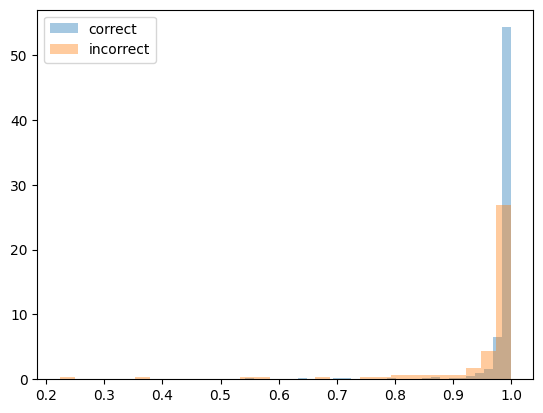

In [34]:
import matplotlib.pyplot as plt

df_agg['max_max_el'] = df_agg['max'].apply(lambda x: np.max(x))

# plt.hist(df_agg['max_max_el'], bins=10, density=True, alpha=0.4, label="correct");

plt.hist(df_agg[df_agg['pred_max']==df_agg['answer']]['max_max_el'], bins=30, density=True, alpha=0.4, label="correct");
plt.hist(df_agg[df_agg['pred_max']!=df_agg['answer']]['max_max_el'], bins=30, density=True, alpha=0.4, label="incorrect");

plt.legend();

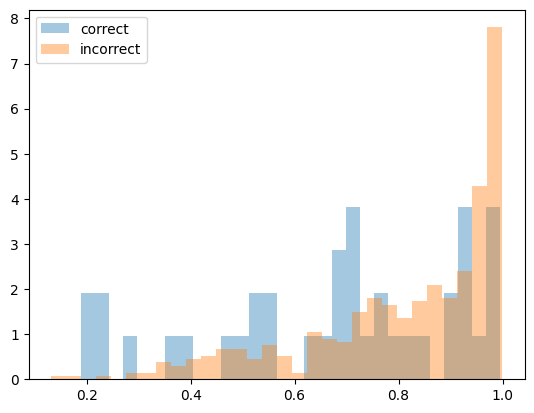

In [35]:
df_agg['avg_of_max'] = df_agg['max'].apply(lambda x: np.average(x))

plt.hist(df_agg[df_agg['pred_diff_max']==df_agg['answer']]['avg_of_max'], bins=30, density=True, alpha=0.4, label="correct");
plt.hist(df_agg[df_agg['pred_diff_max']!=df_agg['answer']]['avg_of_max'], bins=30, density=True, alpha=0.4, label="incorrect");

plt.legend();

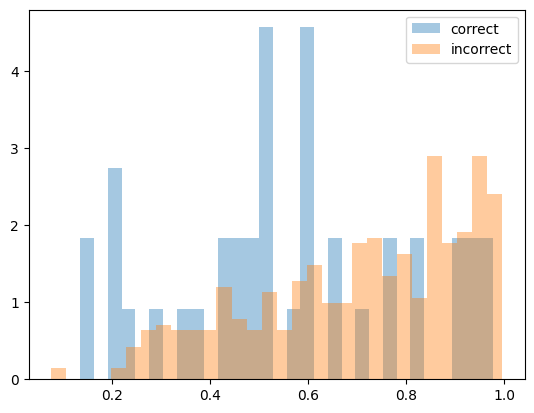

In [36]:
df_agg['avg_of_avg'] = df_agg['avg'].apply(lambda x: np.average(x))

plt.hist(df_agg[df_agg['pred_diff_max']==df_agg['answer']]['avg_of_avg'], bins=30, density=True, alpha=0.4, label="correct");
plt.hist(df_agg[df_agg['pred_diff_max']!=df_agg['answer']]['avg_of_avg'], bins=30, density=True, alpha=0.4, label="incorrect");

plt.legend();

In [37]:
df_2 = df_agg[df_agg['max_max_el'] > 0.9]
np.average(df_2['pred_max']==df_2['answer'])

0.790356394129979

In [38]:
df_2 = df_agg[df_agg['max_max_el'] < 0.9]
np.average(df_2['pred_avg_2']==df_2['answer'])

0.34782608695652173

In [39]:
# create "combined_prediction" as follows: where df_agg['max_max_el'] > 0.9, take pred_max, otherwise take pred_avg_2
df_agg['combined_prediction'] = df_agg.apply(lambda row: row['pred_max'] if row['max_max_el'] > 0.9 else row['pred_avg_2'], axis=1)

np.average(df_agg['combined_prediction']==df_agg['answer'])

0.77

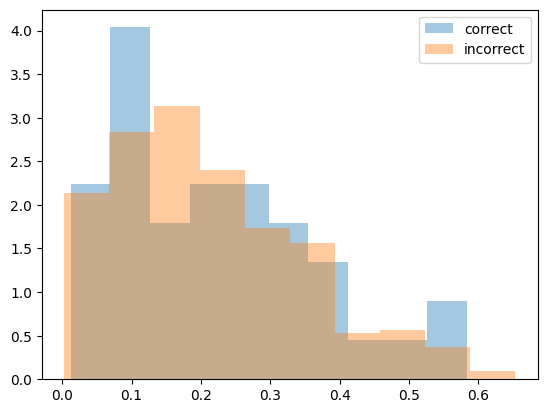

In [40]:
plt.hist(df_agg[(df_agg['pred_diff_max']==df_agg['answer'])]['diff_max_max_el'], bins=10, density=True, alpha=0.4, label="correct");
plt.hist(df_agg[(df_agg['pred_diff_max']!=df_agg['answer'])]['diff_max_max_el'], bins=10, density=True, alpha=0.4, label="incorrect");
plt.legend();

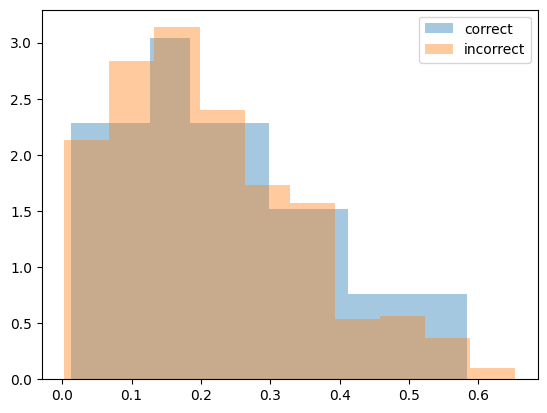

In [41]:
plt.hist(df_agg[(df_agg['pred_diff_max']==df_agg['answer']) & (df_agg['pred_max']==df_agg['answer'])]['diff_max_max_el'], bins=10, density=True, alpha=0.4, label="correct");
plt.hist(df_agg[(df_agg['pred_diff_max']!=df_agg['answer']) & (df_agg['pred_diff_max']!=df_agg['answer'])]['diff_max_max_el'], bins=10, density=True, alpha=0.4, label="incorrect");
plt.legend();

In [42]:
df_agg

,id,answer,avg,max,diff_max,answers,pred_avg,pred_max,pred_diff_max,pred_avg_2,...,avg_prediction,max_prediction,diff_max_max_el,pred_diff_max_max_avg,pred_diff_max_max_max,pred_diff_max_diff_max_max,max_max_el,avg_of_max,avg_of_avg,combined_prediction
0,0,D,"[0.7841864824295044, 0.365252951780955, 0.3408...","[0.8101109862327576, 0.4729377329349518, 0.436...","[0.025924503803253174, 0.10768478115399677, 0....",D,A,A,B,D,...,A D B,A D B,0.107685,0.784186,0.810111,0.107685,0.810111,0.522272,0.465887,D
1,1,D,"[0.01348709903488105, 0.04889114268801429, 0.0...","[0.023958779871463776, 0.07085713744163513, 0....","[0.010471680836582726, 0.021965994753620842, 0...",D,D,D,D,E,...,D E C,D E C,0.210966,0.330769,0.541735,0.210966,0.541735,0.220330,0.135929,E
2,2,A,"[0.022143802295128506, 0.06562760596474011, 0....","[0.03270862624049187, 0.10062923282384872, 0.2...","[0.010564823945363361, 0.03500162685910861, 0....",A,C,C,C,E,...,C E B,C E B,0.103654,0.119930,0.223584,0.103654,0.223584,0.131853,0.076071,E
3,3,B,"[0.2759467549622059, 0.4401126056909561, 0.338...","[0.5398164391517639, 0.48443925380706787, 0.42...","[0.26386968418955803, 0.044326648116111755, 0....",B,B,A,A,C,...,B C E,A B C,0.263870,0.440113,0.539816,0.263870,0.539816,0.411736,0.298440,C
4,4,A,"[0.7641253603829278, 0.2921374539534251, 0.241...","[0.9774370193481445, 0.4866539537906647, 0.497...","[0.21331165896521675, 0.19451649983723956, 0.2...",A,A,A,D,B,...,A B D,A D E,0.499348,0.764125,0.977437,0.499348,0.977437,0.682440,0.357596,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,C,"[0.534287840127945, 0.14227384328842163, 0.988...","[0.7420330047607422, 0.24698862433433533, 0.99...","[0.20774516463279724, 0.1047147810459137, 0.00...",C,C,C,A,A,...,C A E,C A E,0.207745,0.988161,0.995408,0.207745,0.995408,0.549059,0.427025,C
496,496,B,"[0.9662010073661804, 0.9888747096061706, 0.986...","[0.9885849356651306, 0.9983788728713989, 0.996...","[0.022383928298950195, 0.009504163265228294, 0...",B,B,B,E,C,...,B C A,B C A,0.146366,0.988875,0.998379,0.146366,0.998379,0.927087,0.872872,B
497,497,B,"[0.9921214481194814, 0.9936448832352957, 0.973...","[0.9992356300354004, 0.9994922876358032, 0.979...","[0.007114181915918949, 0.005847404400507572, 0...",B,B,B,D,A,...,B A D,B A D,0.009044,0.993645,0.999492,0.009044,0.999492,0.986238,0.979257,B
498,498,D,"[0.7139628529548645, 0.8319788106850216, 0.853...","[0.8354699015617371, 0.9652966260910034, 0.965...","[0.12150704860687256, 0.13331781540598187, 0.1...",D,D,D,E,C,...,D C B,D C B,0.195286,0.954106,0.976501,0.195286,0.976501,0.835516,0.718509,D


In [43]:
df_xgboost = df_agg[['answer', 'avg', 'max', 'diff_max']]
# avg, max and diff_max are arrays. Create avg_0, avg_1, ..., diff_max_0, diff_max_1, ...
for i in range(5):
    df_xgboost[f'avg_{i}'] = df_xgboost['avg'].apply(lambda x: x[i])
for i in range(5):
    df_xgboost[f'max_{i}'] = df_xgboost['max'].apply(lambda x: x[i])
for i in range(5):
    df_xgboost[f'diff_max_{i}'] = df_xgboost['diff_max'].apply(lambda x: x[i])
    
df_xgboost = df_xgboost.drop(columns=['avg', 'max', 'diff_max'])

# convert answer to 0, 1, 2, 3, 4
df_xgboost['answer'] = df_xgboost['answer'].apply(lambda x: option_to_index[x])

df_xgboost

/tmp/ipykernel_2992455/2882938264.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost[f'avg_{i}'] = df_xgboost['avg'].apply(lambda x: x[i])
/tmp/ipykernel_2992455/2882938264.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost[f'avg_{i}'] = df_xgboost['avg'].apply(lambda x: x[i])
/tmp/ipykernel_2992455/2882938264.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,answer,avg_0,avg_1,avg_2,avg_3,avg_4,max_0,max_1,max_2,max_3,max_4,diff_max_0,diff_max_1,diff_max_2,diff_max_3,diff_max_4
0,3,0.784186,0.365253,0.340827,0.722697,0.116472,0.810111,0.472938,0.436626,0.768302,0.123384,0.025925,0.107685,0.095799,0.045604,0.006912
1,3,0.013487,0.048891,0.092969,0.330769,0.193528,0.023959,0.070857,0.149080,0.541735,0.316021,0.010472,0.021966,0.056111,0.210966,0.122492
2,0,0.022144,0.065628,0.119930,0.054070,0.118582,0.032709,0.100629,0.223584,0.089623,0.212720,0.010565,0.035002,0.103654,0.035554,0.094138
3,1,0.275947,0.440113,0.338320,0.122112,0.315707,0.539816,0.484439,0.424694,0.205369,0.404360,0.263870,0.044327,0.086373,0.083257,0.088653
4,0,0.764125,0.292137,0.241704,0.249995,0.240017,0.977437,0.486654,0.497665,0.749343,0.701101,0.213312,0.194516,0.255961,0.499348,0.461084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2,0.534288,0.142274,0.988161,0.145874,0.324528,0.742033,0.246989,0.995408,0.303479,0.457387,0.207745,0.104715,0.007247,0.157604,0.132858
496,1,0.966201,0.988875,0.986837,0.861394,0.561052,0.988585,0.998379,0.996732,0.944320,0.707418,0.022384,0.009504,0.009894,0.082926,0.146366
497,1,0.992121,0.993645,0.973349,0.974997,0.962173,0.999236,0.999492,0.979549,0.984041,0.968870,0.007114,0.005847,0.006200,0.009044,0.006696
498,3,0.713963,0.831979,0.853099,0.954106,0.239397,0.835470,0.965297,0.965631,0.976501,0.434683,0.121507,0.133318,0.112532,0.022394,0.195286


In [44]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X = df_xgboost.drop(columns="answer")
y = df_xgboost["answer"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert the datasets into DMatrix instances, which is the data structure XGBoost uses
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the XGBoost model
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'multi:softprob',  # for multiclass classification problems
    'num_class': 5  # you mentioned 5 possible values for the answer column
}
num_round =30

# Train the model
bst = xgb.train(param, dtrain, num_round)

# Make predictions
preds_prob = bst.predict(dtest)
preds = preds_prob.argmax(axis=1)

# Evaluate the model
acc = accuracy_score(y_test, preds)
print(f"Accuracy: {acc}")

Accuracy: 0.6733333333333333


In [45]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# Normalize the features
scaler = StandardScaler()
features = df_xgboost.drop(columns="answer").values
features = scaler.fit_transform(features)


X = torch.tensor(features, dtype=torch.float32)
y = torch.tensor(df_xgboost["answer"].values, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = X.shape[1]
output_dim = 5  # As there are 5 possible classes
model = SimpleNN(input_dim, output_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
        
        with torch.no_grad():
            test_outputs = model(X_test)
            _, predicted = test_outputs.max(1)
            acc = accuracy_score(y_test, predicted)
            print(f"Test Accuracy: {acc * 100:.2f}%")

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = test_outputs.max(1)
    acc = accuracy_score(y_test, predicted)
    print(f"Test Accuracy: {acc * 100:.2f}%")

Epoch [10/300], Loss: 1.5525
Test Accuracy: 31.00%
Epoch [20/300], Loss: 1.4513
Test Accuracy: 39.00%
Epoch [30/300], Loss: 1.3303
Test Accuracy: 45.00%
Epoch [40/300], Loss: 1.1997
Test Accuracy: 48.00%
Epoch [50/300], Loss: 1.0828
Test Accuracy: 51.00%
Epoch [60/300], Loss: 0.9886
Test Accuracy: 53.00%
Epoch [70/300], Loss: 0.9135
Test Accuracy: 56.00%
Epoch [80/300], Loss: 0.8535
Test Accuracy: 58.00%
Epoch [90/300], Loss: 0.8046
Test Accuracy: 58.00%
Epoch [100/300], Loss: 0.7625
Test Accuracy: 57.00%
Epoch [110/300], Loss: 0.7248
Test Accuracy: 58.00%
Epoch [120/300], Loss: 0.6908
Test Accuracy: 58.00%
Epoch [130/300], Loss: 0.6597
Test Accuracy: 59.00%
Epoch [140/300], Loss: 0.6303
Test Accuracy: 60.00%
Epoch [150/300], Loss: 0.6041
Test Accuracy: 59.00%
Epoch [160/300], Loss: 0.5794
Test Accuracy: 59.00%
Epoch [170/300], Loss: 0.5556
Test Accuracy: 58.00%
Epoch [180/300], Loss: 0.5325
Test Accuracy: 58.00%
Epoch [190/300], Loss: 0.5105
Test Accuracy: 59.00%
Epoch [200/300], Loss